In [1]:
import json, glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

from astropy.io import fits
from astropy.io import ascii
from astropy.wcs import WCS
import astropy.io.fits as pyfits
from astropy.nddata.utils import Cutout2D

from reproject import reproject_interp, reproject_adaptive
# from definitions import *

### Test

In [3]:
Subaru_file = glob.glob('./images/subaru*/0001*v1.fits')
with fits.open(Subaru_file[0]) as f:
                HST_image = f[0].data
                HST_header = f[0].header
sorted(Subaru_file)

['./images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA427.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA464.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA484.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA505.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA527.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA574.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA624.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA679.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA709.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549

In [4]:
n = "0001"
HST_file = glob.glob(f'./images/acs*/{n}_*.fits')
Subaru_file_r = sorted(glob.glob(f'./images/subaru*/{n}_*v2.fits'))
Subaru_file_r

['./images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.B.original_psf.v2.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.NB816.original_psf.v2.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.V.original_psf.v2.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.gp.original_psf.v2.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.ip.original_psf.v2.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.rp.original_psf.v2.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.zp.original_psf.v2.fits']

In [70]:
def multi_filter_plot(n, area, resolution='30mas', size=7, kernel='hann', save=False):
    
    loc = '/mnt/D/JWST_data/COSMOS-Webb/'
    HST_file = glob.glob(f'./images/acs*/{n}_*.fits')
    Subaru_file_r = sorted(glob.glob(f'./images/subaru*/{n}_*v1.fits'))
    candi = pd.read_csv('../CentralDogma/5_Wrath_/magv5_eye_auto.csv')
    
    n = int(n) - 1
    
    ra, dec = candi['ALPHA_J2000_F444W'][n], candi['DELTA_J2000_F444W'][n]
    print(ra, dec)
    
    images = {}
    headers = {}
    WCSs = {}
    pix_sizes = {}
    
    Subaru_file = [Subaru_file_r[0], Subaru_file_r[2], Subaru_file_r[4], Subaru_file_r[6], Subaru_file_r[8]]
    
    filters = ["F115W", "F150W", "F277W", "F444W"]
    subaru_filters = ["IA427", "IA484", "IA527", "IA624", "IA709"]
    # subaru_filters = ["IA427", "IA464", "IA484", "IA505", "IA527", "IA574", "IA624"]
    
    for f in range(len(filters)):
        with fits.open(loc + f"{resolution}/SCI/mosaic_nircam_{filters[f].lower()}_COSMOS-Web_{resolution}_A{area}_v0_5_SCI.fits") as hdul:
            images[filters[f]] = hdul[1].data
            headers[filters[f]] = hdul[1].header
            WCSs[filters[f]] = WCS(hdul[1].header)
            pix_sizes[filters[f]] = np.sqrt(hdul[1].header['PIXAR_A2'])
            print(np.sqrt(hdul[1].header['PIXAR_A2']))
    
    fig = plt.figure(figsize=(25, 11))
    
    # HST figure
    
    with fits.open(HST_file[0]) as f:
                HST_image = f[0].data
                HST_header = f[0].header
                
    HST_WCS = WCS(HST_header)
    HST_pix_size = abs(HST_header['CDELT1']*3600) # [arcsec]
    # print(HST_pix_size)
    x_hst, y_hst = HST_WCS.all_world2pix(ra, dec, 0)
    
    # x_hst -= HST_ra_offset*3600/HST_pix_size
    # y_hst -= HST_dec_offset*3600/HST_pix_size
    
    print("Reprojecting HST image......")
    # scale = 1.414
    scale = 1
    
    y_start = max(0, int(y_hst - size*scale))
    y_end = min(HST_image.shape[0], int(y_hst + size*scale))
    x_start = max(0, int(x_hst - size*scale))
    x_end = min(HST_image.shape[1], int(x_hst + size*scale))

    cut_data_shape = (int(2*size*scale), int(2*size*scale))
    HST_img_center = np.full(cut_data_shape, np.nan)

    y_offset = max(0, int(size*scale - y_hst))
    x_offset = max(0, int(size*scale - x_hst))

    HST_img_center = HST_image[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = HST_image[y_start:y_end, x_start:x_end]
    
    HST_header["NAXIS1"] = HST_img_center.shape[1]
    HST_header["NAXIS2"] = HST_img_center.shape[0]
    headers["F444W"]["NAXIS1"] = HST_img_center.shape[1]
    headers["F444W"]["NAXIS2"] = HST_img_center.shape[0]
    
    HST_WCS = WCS(HST_header)
    # JWST_WCS = WCS(headers["F444W"])
    
    # return HST_WCS, JWST_WCS
    
    # Measure the rotation of the JWST WCS
    # theta = -np.arctan(JWST_WCS.wcs.pc[1, 0]/JWST_WCS.wcs.pc[0, 0])
    theta2 = -np.arctan(HST_WCS.wcs.cd[1, 0]/HST_WCS.wcs.cd[0, 0])
    # print(theta, theta2)
    
    # Re-define the input and output WCS by changing the rotation angle
    # input_wcs = HST_WCS.deepcopy()
    # input_wcs.wcs.crpix = HST_img_center.shape[1]/2, HST_img_center.shape[0]/2
    # input_wcs.wcs.cdelt = HST_pix_size/3600, HST_pix_size/3600
    
    # output_wcs = input_wcs.deepcopy()
    # output_wcs.wcs.crpix = HST_img_center.shape[1]/2, HST_img_center.shape[0]/2
    # output_wcs.wcs.pc = [[-np.cos(theta), 
    #                     np.sin(theta)], 
    #                     [np.sin(theta), 
    #                     np.cos(theta)]]
    # output_wcs.wcs.cdelt = HST_pix_size/3600/scale, HST_pix_size/3600/scale
    
    # # Define the shape of the output image
    # shape_out = (HST_img_center.shape[1], HST_img_center.shape[0])
    # # print(shape_out, HST_img_center.shape, cut_data_shape)
    
    # # Reproject the HST image on newly defined WCS  
    # HST_img_center = reproject_adaptive((HST_img_center, input_wcs),
    #                                     output_wcs, shape_out=shape_out,
    #                                     kernel=kernel,
    #                                     return_footprint=False)
    
    # ax = fig.add_subplot(2, 5, 6, projection=output_wcs)
    ax = fig.add_subplot(2, 5, 6, projection=WCSs[filters[0]])
    ax.imshow(HST_img_center,
                cmap='viridis',
                vmax=np.nanpercentile(HST_img_center, 99),
                vmin=np.nanpercentile(HST_img_center, 10)
                )
    
    # Plot center indicator of the center of the image
    ax.plot([size*scale, size*scale], [size*scale+0.5/HST_pix_size, size*scale+1/HST_pix_size], color='red', lw=3)
    ax.plot([size*scale+0.5/HST_pix_size, size*scale+1/HST_pix_size], [size*scale, size*scale], color='red', lw=3)
    
    # mag = round(row[f'{filters[f]}_MAG_AUTO'], 3)
    # mag_err = round(row[f'{filters[f]}_MAGERR_AUTO'], 3)
    ax.set_title("HST F814W", fontsize=30)
    # Hiding x and y axis ticks on regular axis
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    
    # # Subaru figure
    # if Subaru_file != 'nan':
        
    #     # for i in range(len(subaru_filters)):
    #     for i in range(len(Subaru_file)):
            
    #         with fits.open(Subaru_file[i]) as f:
    #             Subaru_image = f[0].data
    #             Subaru_header = f[0].header

    #         Subaru_WCS = WCS(Subaru_header)
    #         Subaru_pix_size = abs(Subaru_header['CD2_2']*3600)
    #         # print(Subaru_pix_size)
            
    #         x_subaru, y_subaru = Subaru_WCS.all_world2pix(ra, dec, 0)
            
    #         print("Reprojecting Subaru image......")
    #         # scale = 1.414
            
    #         size2 = size * HST_pix_size/Subaru_pix_size
            
    #         y_start = max(0, int(y_subaru - size2*scale))
    #         y_end = min(Subaru_image.shape[0], int(y_subaru + size2*scale))
    #         x_start = max(0, int(x_subaru - size2*scale))
    #         x_end = min(Subaru_image.shape[1], int(x_subaru + size2*scale))
            
    #         cut_data_shape = (int(2*size2*scale), int(2*size2*scale))
    #         Subaru_img_center = np.full(cut_data_shape, np.nan)
            
    #         y_offset = max(0, int(size2*scale - y_subaru))
    #         x_offset = max(0, int(size2*scale - x_subaru))
            
    #         Subaru_img_center = Subaru_image[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = Subaru_image[y_start:y_end, x_start:x_end]
            
    #         Subaru_header["NAXIS1"] = Subaru_img_center.shape[1]
    #         Subaru_header["NAXIS2"] = Subaru_img_center.shape[0]
            
    #         Subaru_WCS = WCS(Subaru_header)
            
    #         # Re-define the input and output WCS by changing the rotation angle
    #         input_wcs = Subaru_WCS.deepcopy()
    #         input_wcs.wcs.crpix = Subaru_img_center.shape[1]/2, Subaru_img_center.shape[0]/2
    #         input_wcs.wcs.cdelt = Subaru_pix_size/3600, Subaru_pix_size/3600
            
    #         output_wcs = input_wcs.deepcopy()
    #         output_wcs.wcs.crpix = Subaru_img_center.shape[1]/2, Subaru_img_center.shape[0]/2
    #         output_wcs.wcs.pc = [[-np.cos(theta), 
    #                             np.sin(theta)], 
    #                             [np.sin(theta), 
    #                             np.cos(theta)]]
    #         output_wcs.wcs.cdelt = Subaru_pix_size/3600/scale, Subaru_pix_size/3600/scale
            
    #         # Define the shape of the output image
    #         shape_out = (Subaru_img_center.shape[1], Subaru_img_center.shape[0])
            
    #         # Reproject the Subaru image on newly defined WCS
    #         Subaru_img_center = reproject_adaptive((Subaru_img_center, input_wcs),
    #                                             output_wcs, shape_out=shape_out,
    #                                             kernel=kernel,
    #                                             return_footprint=False)
            
    #         ax = fig.add_subplot(2, 5, 1+i, projection=output_wcs)
    #         ax.imshow(Subaru_img_center,
    #                     cmap='viridis',
    #                     vmax=np.nanpercentile(Subaru_img_center, 99),
    #                     vmin=np.nanpercentile(Subaru_img_center, 10)
    #                     )
            
    #         # Plot center indicator of the center of the image
    #         ax.plot([size2*scale, size2*scale], [size2*scale+0.5/Subaru_pix_size, size2*scale+1/Subaru_pix_size], color='red', lw=3)
    #         ax.plot([size2*scale+0.5/Subaru_pix_size, size2*scale+1/Subaru_pix_size], [size2*scale, size2*scale], color='red', lw=3)
            
    #         ax.set_title('SUPRIME-CAM '+subaru_filters[i], fontsize=30)
    #         ax.coords[0].set_ticks_visible(False)
    #         ax.coords[0].set_ticklabel_visible(False)
    #         ax.coords[1].set_ticks_visible(False)
    #         ax.coords[1].set_ticklabel_visible(False)
    # else:
    #     print("No Subaru image found")
        
    # # plot data from JWST
    for f in range(len(filters)):
        ax = fig.add_subplot(2, 5, f+7, projection=WCSs[filters[f]])
        img_data = images[filters[f]]
        # print(img_data.shape)
        
        # Calibrate the coordinate to F444W image
        # ra_offset, dec_offset = all_offsets[filters[f]]
        # print(ra_offset, dec_offset)
        # x_single = row[f'{filters[f]}_X_IMAGE'] - ra_offset*3600/pix_sizes[filters[f]]
        # y_single = row[f'{filters[f]}_Y_IMAGE'] - dec_offset*3600/pix_sizes[filters[f]]
        x_single, y_single = WCSs[filters[f]].all_world2pix(ra, dec, 0)
        # print(x_single, y_single)
        
        scale = 1.414
        
        # Plot the image
        y_start = max(0, int(y_single - size*scale))
        y_end = min(img_data.shape[0], int(y_single + size*scale))
        x_start = max(0, int(x_single - size*scale))
        x_end = min(img_data.shape[1], int(x_single + size*scale))

        cut_data_shape = (int(2*size*scale), int(2*size*scale))
        img_center = np.full(cut_data_shape, np.nan)

        y_offset = max(0, int(size*scale - y_single))
        x_offset = max(0, int(size*scale - x_single))
        
        # if y_end-y_start != 
        
        print(y_offset, y_offset+(y_end-y_start), x_offset, x_offset+(x_end-x_start), img_data.shape, img_center.shape)
        
        img_center[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = img_data[y_start:y_end, x_start:x_end]
        
        
        JWST_WCS = WCS(headers[filters[f]])
        
        # Re-define the input and output WCS by changing the rotation angle
        input_wcs = JWST_WCS.deepcopy()
        input_wcs.wcs.crpix = img_center.shape[1]/2, img_center.shape[0]/2
        input_wcs.wcs.cdelt = pix_sizes[filters[f]]/3600, pix_sizes[filters[f]]/3600
        
        output_wcs = input_wcs.deepcopy()
        output_wcs.wcs.crpix = img_center.shape[1]/2, img_center.shape[0]/2
        output_wcs.wcs.pc = [[-np.cos(theta2), 
                            np.sin(theta2)], 
                            [np.sin(theta2), 
                            np.cos(theta2)]]
        output_wcs.wcs.cdelt = pix_sizes[filters[f]]/3600/scale, pix_sizes[filters[f]]/3600/scale
        
        # Define the shape of the output image
        shape_out = (img_center.shape[1], img_center.shape[0])
        # print(shape_out, HST_img_center.shape, cut_data_shape)
        
        # Reproject the HST image on newly defined WCS  
        img_center = reproject_adaptive((img_center, input_wcs),
                                            output_wcs, shape_out=shape_out,
                                            kernel=kernel,
                                            return_footprint=False)
    
        
        ax.imshow(img_center, 
                vmax=np.nanpercentile(img_center.flatten(), 99), 
                vmin=np.nanpercentile(img_center.flatten(), 10)
                )

        # Plot indicator of the center of the image
        ax.plot([size, size], [size+0.5/pix_sizes[filters[f]], size+1/pix_sizes[filters[f]]], color='red', lw=3)
        ax.plot([size+0.5/pix_sizes[filters[f]], size+1/pix_sizes[filters[f]]], [size, size], color='red', lw=3)

        mag = round(candi[f'MAG_AUTO_{filters[f]}'][n], 3)
        mag_err = round(candi[f'MAGERR_AUTO_{filters[f]}'][n], 3)
        ax.set_title(f"{filters[f]} \n {mag}$\pm${mag_err}" , fontsize=27)
        
        # Hiding x and y axis ticks
        ax.coords[0].set_ticks_visible(False) 
        ax.coords[0].set_ticklabel_visible(False) 
        ax.coords[1].set_ticks_visible(False)
        ax.coords[1].set_ticklabel_visible(False)
        
    # if save:
    #     plt.savefig(f'./images/bd_{n}.png') 


149.8202867866695 2.2452910822686367
0.03
0.03
0.029999999999999985
0.029999999999999985
Reprojecting HST image......
0 149 0 150 (24910, 19200) (149, 149)


ValueError: could not broadcast input array from shape (149,150) into shape (149,149)

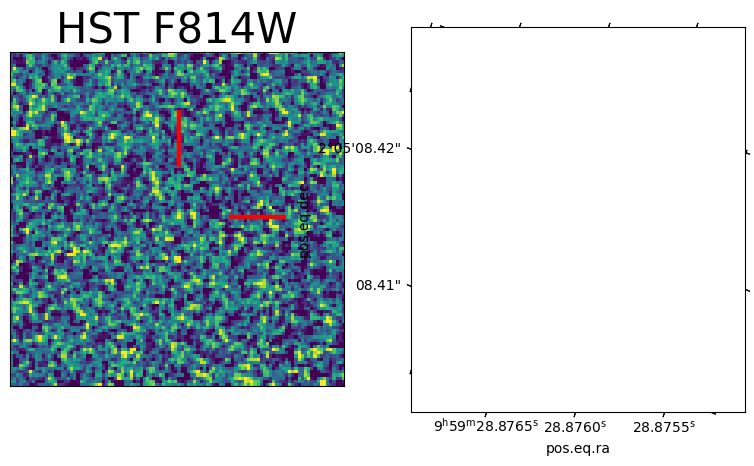

In [71]:
multi_filter_plot("0003", 1, size=53)

In [32]:
# a, b = multi_filter_plot("0005", 6, size=70)
a, b = multi_filter_plot("0001", 1, size=70)

149.7932678830811 2.150532635902282
Reprojecting HST image......


<Figure size 2500x1100 with 0 Axes>

In [29]:
a

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1163213  2.200973097  
CRPIX : -38621.8  6166.667  
CD1_1 CD1_2  : -8.333333e-06  0.0  
CD2_1 CD2_2  : 0.0  8.333333e-06  
NAXIS : 198  198

In [30]:
b

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1163213  2.200973097  
CRPIX : -22989.0  23091.0  
PC1_1 PC1_2  : -0.9396926207859084  0.3420201433256687  
PC2_1 PC2_2  : 0.3420201433256687  0.9396926207859084  
CDELT : 8.33333333333333e-06  8.33333333333333e-06  
NAXIS : 198  198

In [12]:
b

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1163213  2.200973097  
CRPIX : -22989.0  23091.0  
PC1_1 PC1_2  : -0.9396926207859084  0.3420201433256687  
PC2_1 PC2_2  : 0.3420201433256687  0.9396926207859084  
CDELT : 8.33333333333333e-06  8.33333333333333e-06  
NAXIS : 198  198

149.8660388127727 1.966473319192102
Reprojecting HST image......
0.3490658503988659


Reprojecting Subaru image......
Reprojecting Subaru image......
Reprojecting Subaru image......
Reprojecting Subaru image......
Reprojecting Subaru image......


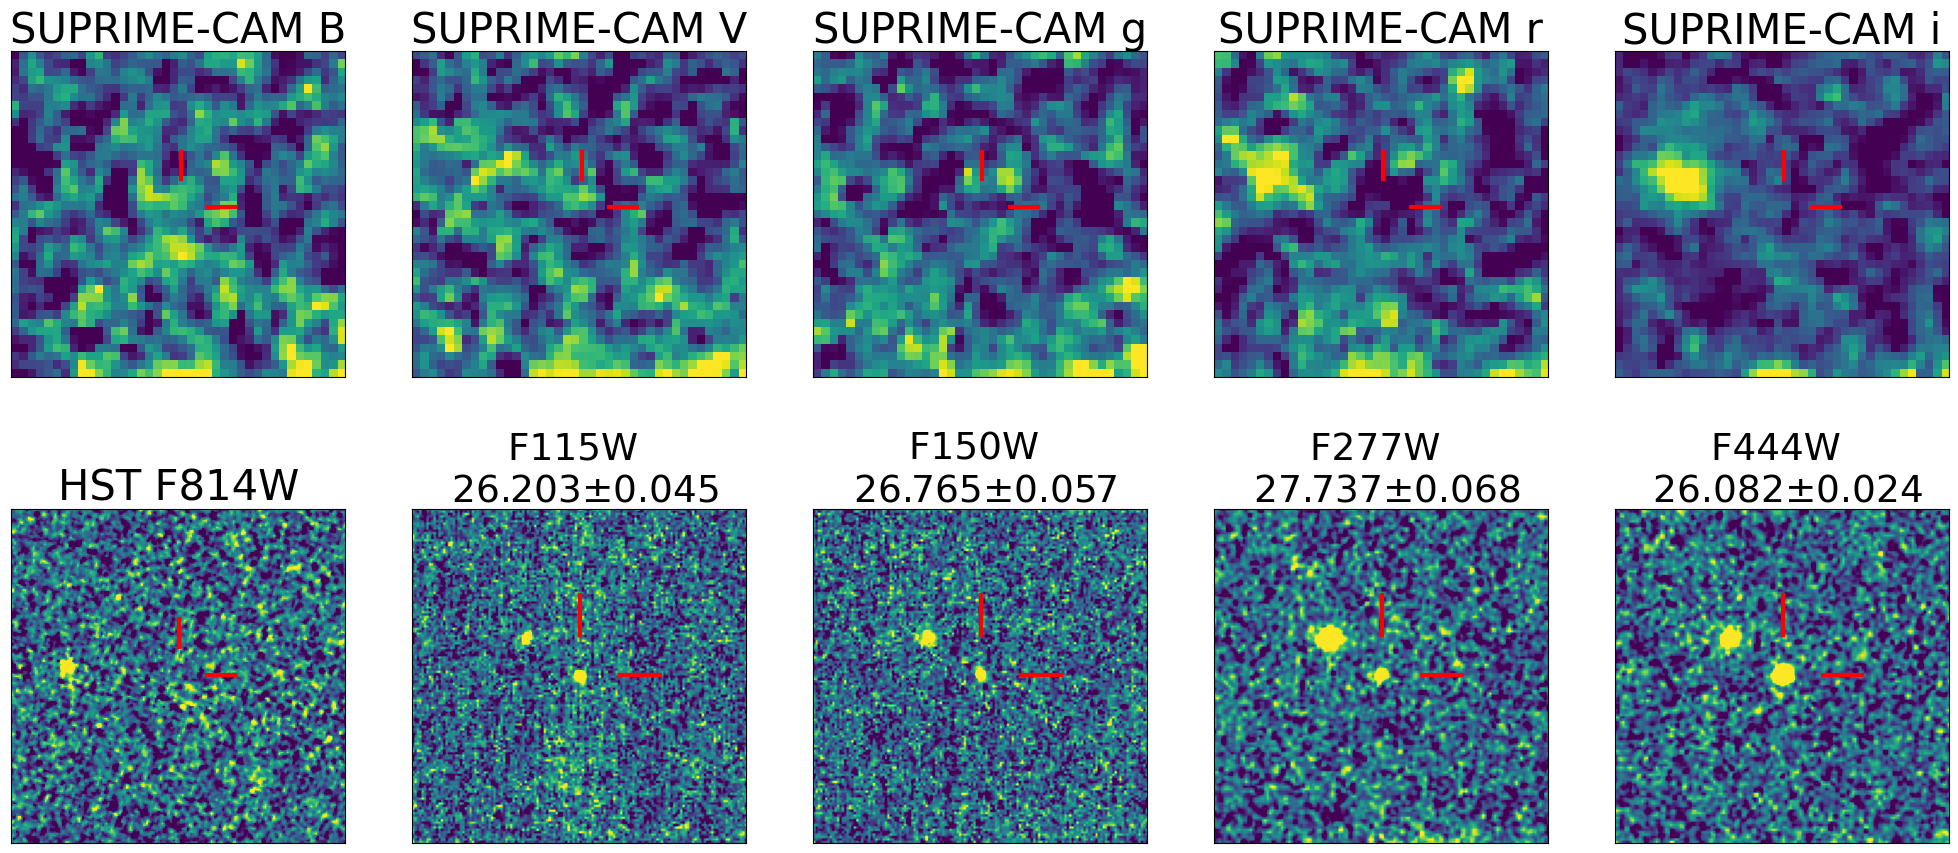

In [47]:
multi_filter_plot("0007", 7, size=70)

In [43]:
multi_filter_plot("0005", 6, size=70)

149.7769783338399 1.9438679369374463
Reprojecting HST image......
0.3490658503988659
Reprojecting Subaru image......
Reprojecting Subaru image......
Reprojecting Subaru image......
Reprojecting Subaru image......
Reprojecting Subaru image......


### get ccor

In [7]:
data = pd.read_csv('../CentralDogma/5_Wrath_/selectedv5.csv')
coor = data[['ALPHA_J2000_F444W', 'DELTA_J2000_F444W']]
coor.to_csv('../CentralDogma/5_Wrath_/coor.csv', index=False)

In [11]:
Subaru_file_r = sorted(glob.glob(f'./images/subaru*/*v1.fits'))
print(len(Subaru_file_r))

767


In [10]:
metamag = pd.read_csv('../CentralDogma/5_Wrath_/bd_crossed_new.csv')
metamag['acs_f814w_mag'][0]

nan

### plot

In [2]:
def round_to_significant_digit(value, error):
    
    ''' determine the number of significant digits in the error and round the value to match the error's precision
    Parameters:
    value: float or int
        the value to be rounded
    error: float or int
        the error of the value
    Returns:
    rounded_value: float
        the value rounded to the same precision as the error
    rounded_error: float
        the error rounded to its significant
    ''' 
    
    value = float(value)
    error = float(error)
    
    # Find the first non-zero digit in the error
    significant_digits = -int(f"{error:e}".split('e')[1])
    
    # Round the error to its significant digits
    rounded_error = round(error, significant_digits)
    # in case 0.96 is rounded to 1.0
    significant_digits = -int(f"{rounded_error:e}".split('e')[1])
    
    # Round the value to match the error's precision
    rounded_value = round(value, significant_digits)
    
    return rounded_value, rounded_error

In [3]:
def multi_filter_plot(
    n, area, resolution='30mas', size=7, kernel='hann',
    gsmooth=0, percentage=[10, 99],
    offset=True, save=False
    ):
    
    ''' Plot the multi-filter images of a source from HST, Subaru, and JWST
    Parameters:
    n: str
        the id of the source
    area: int
        the area of the image
    resolution: str
        the resolution of the JWST image
    size: int
        the size of the image
    kernel: str
        the kernel used in reproject_adaptive
    gsmooth: int
        the sigma of the gaussian smoothing
    percentage: list
        the percentage of the colorbar
    offset: bool
        whether to consider the offset of the source
    save: bool
        whether to save the image
    '''
    
    loc = '/mnt/D/JWST_data/COSMOS-Webb/'
    HST_file = glob.glob(f'./images/acs*/{n}_*.fits')
    Subaru_file_r = sorted(glob.glob(f'./images/subaru*/{n}_*v1.fits'))
    # /bd59
    
    # candi = pd.read_csv('../CentralDogma/5_Wrath_/selectedv5.csv')
    metamag = pd.read_csv('../CentralDogma/4_Greed_/bd29xCOSMOS2020.csv')
    # candi = pd.read_csv('../CentralDogma/4_Greed_/selected.csv')
    candi = pd.read_csv('../CentralDogma/4_Greed_/good.csv')
    # metamag = []
    
    # go through the metamag to find the corresponding id
    
    for i in range(len(metamag)):
        
        if metamag['BD'][i] == int(n) and pd.notna(metamag['id'][i]):
        # if metamag['id'][i] != 'nan': NaN (Not a Number) is used to denote missing or undefined values, and NaN is not equal to any value, including itself.
            
            seperation = metamag['dist'][i]
            HST_mag = [metamag['acs_f814w_mag'][i], metamag['acs_f814w_magerr'][i]]
            Subaru_427_mag = [metamag['sc_ib427_mag_auto'][i], metamag['sc_ib427_magerr_auto'][i]]
            Subaru_484_mag = [metamag['sc_ia484_mag_auto'][i], metamag['sc_ia484_magerr_auto'][i]]
            Subaru_527_mag = [metamag['sc_ia527_mag_auto'][i], metamag['sc_ia527_magerr_auto'][i]]
            Subaru_624_mag = [metamag['sc_ia624_mag_auto'][i], metamag['sc_ia624_magerr_auto'][i]]
            Subaru_709_mag = [metamag['sc_ib709_mag_auto'][i], metamag['sc_ib709_magerr_auto'][i]]
            # print(HST_mag)
            break
        
        else:
            seperation = np.nan
            HST_mag = [np.nan, np.nan]
            Subaru_427_mag = Subaru_484_mag = Subaru_527_mag = Subaru_624_mag = Subaru_709_mag = [np.nan ,np.nan]
            
    if len(metamag) == 0:
        seperation = np.nan
        HST_mag = [np.nan, np.nan]
        Subaru_427_mag = Subaru_484_mag = Subaru_527_mag = Subaru_624_mag = Subaru_709_mag = [np.nan ,np.nan]
    else:
        pass
    
    print(HST_mag)
    print(Subaru_427_mag)
    
    BDid = int(n)
    
    n = int(n) - 1 # n from id(59) to index
    
    ra, dec = candi['ALPHA_J2000_F444W'][n], candi['DELTA_J2000_F444W'][n]
    print(ra, dec)
    
    images = {}
    headers = {}
    WCSs = {}
    pix_sizes = {}
    
    Subaru_file = [Subaru_file_r[0], Subaru_file_r[2], Subaru_file_r[4], Subaru_file_r[6], Subaru_file_r[8]]
    
    filters = ["F115W", "F150W", "F277W", "F444W"]
    subaru_filters = ["IA427", "IA484", "IA527", "IA624", "IA709"]
    # subaru_filters = ["IA427", "IA464", "IA484", "IA505", "IA527", "IA574", "IA624"]
    
    for f in range(len(filters)):
        with fits.open(loc + f"{resolution}/SCI/mosaic_nircam_{filters[f].lower()}_COSMOS-Web_{resolution}_A{area}_v0_5_SCI.fits") as hdul:
            images[filters[f]] = hdul[1].data
            headers[filters[f]] = hdul[1].header
            WCSs[filters[f]] = WCS(hdul[1].header)
            pix_sizes[filters[f]] = np.sqrt(hdul[1].header['PIXAR_A2'])
            # print(np.sqrt(hdul[1].header['PIXAR_A2']))
    
    fig = plt.figure(figsize=(25, 11))
    
    # HST figure
    
    with fits.open(HST_file[0]) as f:
                HST_image = f[0].data
                HST_header = f[0].header
                
    HST_WCS = WCS(HST_header)
    HST_pix_size = abs(HST_header['CDELT1']*3600) # [arcsec]
    # print(HST_pix_size)
    x_hst, y_hst = HST_WCS.all_world2pix(ra, dec, 0)
    
    # x_hst -= HST_ra_offset*3600/HST_pix_size
    # y_hst -= HST_dec_offset*3600/HST_pix_size
    
    # print("Reprojecting HST image......")
    scale = 1.414
    
    y_start = max(0, int(y_hst - size*scale))
    y_end = min(HST_image.shape[0], int(y_hst + size*scale))
    x_start = max(0, int(x_hst - size*scale))
    x_end = min(HST_image.shape[1], int(x_hst + size*scale))

    cut_data_shape = (int(2*size*scale), int(2*size*scale))
    HST_img_center = np.full(cut_data_shape, np.nan)

    y_offset = max(0, int(size*scale - y_hst))
    x_offset = max(0, int(size*scale - x_hst))
    # y_offset = int(size*scale - y_hst)
    # x_offset = int(size*scale - x_hst)
    # print(y_offset, x_offset)
    # HST_img_center = HST_image[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = HST_image[y_start:y_end, x_start:x_end]
    
    HST_img_center = HST_image[int(y_hst-scale*size):int(y_hst+scale*size), int(x_hst-scale*size):int(x_hst+scale*size)]
        
    
    HST_header["NAXIS1"] = HST_img_center.shape[1]
    HST_header["NAXIS2"] = HST_img_center.shape[0]
    headers["F444W"]["NAXIS1"] = HST_img_center.shape[1]
    headers["F444W"]["NAXIS2"] = HST_img_center.shape[0]
    
    HST_WCS = WCS(HST_header)
    JWST_WCS = WCS(headers["F444W"])
    # Measure the rotation of the JWST WCS
    theta = -np.arctan(JWST_WCS.wcs.pc[1, 0]/JWST_WCS.wcs.pc[0, 0])
    # print(theta)
    
    # Re-define the input and output WCS by changing the rotation angle
    input_wcs = HST_WCS.deepcopy()
    input_wcs.wcs.crpix = HST_img_center.shape[1]/2, HST_img_center.shape[0]/2
    input_wcs.wcs.cdelt = HST_pix_size/3600, HST_pix_size/3600
    
    output_wcs = input_wcs.deepcopy()
    output_wcs.wcs.crpix = HST_img_center.shape[1]/2, HST_img_center.shape[0]/2
    output_wcs.wcs.pc = [[-np.cos(theta), 
                        np.sin(theta)], 
                        [np.sin(theta), 
                        np.cos(theta)]]
    output_wcs.wcs.cdelt = HST_pix_size/3600/scale, HST_pix_size/3600/scale
    
    # Define the shape of the output image
    shape_out = (HST_img_center.shape[1], HST_img_center.shape[0])
    # print(shape_out, HST_img_center.shape, cut_data_shape)
    
    # Reproject the HST image on newly defined WCS  
    HST_img_center = reproject_adaptive((HST_img_center, input_wcs),
                                        output_wcs, shape_out=shape_out,
                                        kernel=kernel,
                                        return_footprint=False)
    
    # gaussian smoothing
    if gsmooth != 0:
        HST_img_center = gaussian_filter(HST_img_center, sigma=gsmooth)
    else:
        pass
    
    ax = fig.add_subplot(2, 5, 6, projection=output_wcs)
    ax.imshow(HST_img_center,
                cmap='viridis',
                vmax=np.nanpercentile(HST_img_center, percentage[1]),
                vmin=np.nanpercentile(HST_img_center, percentage[0])
                )
    
    # Plot center indicator of the center of the image
    ax.plot([size*scale, size*scale], [size*scale+0.5/HST_pix_size, size*scale+1/HST_pix_size], color='red', lw=3)
    ax.plot([size*scale+0.5/HST_pix_size, size*scale+1/HST_pix_size], [size*scale, size*scale], color='red', lw=3)
    
    if pd.notna(HST_mag[0]):
        mag, err = round_to_significant_digit(HST_mag[0], HST_mag[1])
        ax.set_title(f"HST F814W \n {mag}$\pm${err}", fontsize=27)
    else:
        ax.set_title("HST F814W \n nan", fontsize=27)
    
    # Hiding x and y axis ticks on regular axis
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    
    # Subaru figure
    if Subaru_file != 'nan':
        
        # for i in range(len(subaru_filters)):
        for i in range(len(Subaru_file)):
            
            with fits.open(Subaru_file[i]) as f:
                Subaru_image = f[0].data
                Subaru_header = f[0].header

            Subaru_WCS = WCS(Subaru_header)
            Subaru_pix_size = abs(Subaru_header['CD2_2']*3600)
            # print(Subaru_pix_size)
            
            x_subaru, y_subaru = Subaru_WCS.all_world2pix(ra, dec, 0)
            
            # print("Reprojecting Subaru image......")
            # scale = 1.414
            
            size2 = size * HST_pix_size/Subaru_pix_size
            # size2 = size 
            
            y_start = max(0, int(y_subaru - size2*scale))
            y_end = min(Subaru_image.shape[0], int(y_subaru + size2*scale))
            x_start = max(0, int(x_subaru - size2*scale))
            x_end = min(Subaru_image.shape[1], int(x_subaru + size2*scale))
            
            cut_data_shape = (int(2*size2*scale), int(2*size2*scale))
            Subaru_img_center = np.full(cut_data_shape, np.nan)
            
            y_offset = max(0, int(size2*scale - y_subaru))
            x_offset = max(0, int(size2*scale - x_subaru))
            
            # Subaru_img_center = Subaru_image[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = Subaru_image[y_start:y_end, x_start:x_end]
            
            Subaru_img_center = Subaru_image[int(y_subaru-scale*size2):int(y_subaru+scale*size2), int(x_subaru-scale*size2):int(x_subaru+scale*size2)]
        
            Subaru_header["NAXIS1"] = Subaru_img_center.shape[1]
            Subaru_header["NAXIS2"] = Subaru_img_center.shape[0]
            
            Subaru_WCS = WCS(Subaru_header)
            
            # Re-define the input and output WCS by changing the rotation angle
            input_wcs = Subaru_WCS.deepcopy()
            input_wcs.wcs.crpix = Subaru_img_center.shape[1]/2, Subaru_img_center.shape[0]/2
            input_wcs.wcs.cdelt = Subaru_pix_size/3600, Subaru_pix_size/3600
            
            output_wcs = input_wcs.deepcopy()
            output_wcs.wcs.crpix = Subaru_img_center.shape[1]/2, Subaru_img_center.shape[0]/2
            output_wcs.wcs.pc = [[-np.cos(theta), 
                                np.sin(theta)], 
                                [np.sin(theta), 
                                np.cos(theta)]]
            output_wcs.wcs.cdelt = Subaru_pix_size/3600/scale, Subaru_pix_size/3600/scale
            
            # Define the shape of the output image
            shape_out = (Subaru_img_center.shape[1], Subaru_img_center.shape[0])
            
            # Reproject the Subaru image on newly defined WCS
            Subaru_img_center = reproject_adaptive((Subaru_img_center, input_wcs),
                                                output_wcs, shape_out=shape_out,
                                                kernel=kernel,
                                                return_footprint=False)
            
            # gaussian smoothing
            if gsmooth != 0:
                Subaru_img_center = gaussian_filter(Subaru_img_center, sigma=gsmooth)
            else:
                pass
            
            ax = fig.add_subplot(2, 5, 1+i, projection=output_wcs)
            ax.imshow(Subaru_img_center,
                        cmap='viridis',
                        vmax=np.nanpercentile(Subaru_img_center, percentage[1]),
                        vmin=np.nanpercentile(Subaru_img_center, percentage[0])
                        )
            
            # Plot center indicator of the center of the image
            ax.plot([size2*scale, size2*scale], [size2*scale+0.5/Subaru_pix_size, size2*scale+1/Subaru_pix_size], color='red', lw=3)
            ax.plot([size2*scale+0.5/Subaru_pix_size, size2*scale+1/Subaru_pix_size], [size2*scale, size2*scale], color='red', lw=3)
            
            if subaru_filters[i] == 'IA427':
                if pd.notna(Subaru_427_mag[0]):
                    mag, mag_err = round_to_significant_digit(Subaru_427_mag[0], Subaru_427_mag[1])
                else:
                    mag, mag_err = ['nan', 'nan']
                ax.set_title(f"SC {subaru_filters[i]} \n {mag}$\pm${mag_err}", fontsize=27)
                
            elif subaru_filters[i] == 'IA484':
                if pd.notna(Subaru_484_mag[0]):
                    mag, mag_err = round_to_significant_digit(Subaru_484_mag[0], Subaru_484_mag[1])
                else:
                    mag, mag_err = ['nan', 'nan']
                ax.set_title(f"SC {subaru_filters[i]} \n {mag}$\pm${mag_err}", fontsize=27)
                
            elif subaru_filters[i] == 'IA527':
                if pd.notna(Subaru_527_mag[0]): 
                    mag, mag_err = round_to_significant_digit(Subaru_527_mag[0], Subaru_527_mag[1])
                else:
                    mag, mag_err = ['nan', 'nan']
                ax.set_title(f"SC {subaru_filters[i]} \n {mag}$\pm${mag_err}", fontsize=27)
                
            elif subaru_filters[i] == 'IA624':
                if pd.notna(Subaru_624_mag[0]):
                    mag, mag_err = round_to_significant_digit(Subaru_624_mag[0], Subaru_624_mag[1])
                else:
                    mag, mag_err = ['nan', 'nan']
                ax.set_title(f"SC {subaru_filters[i]} \n {mag}$\pm${mag_err}", fontsize=27)
                
            elif subaru_filters[i] == 'IA709':
                if pd.notna(Subaru_709_mag[0]):
                    mag, mag_err = round_to_significant_digit(Subaru_709_mag[0], Subaru_709_mag[1])
                else:
                    mag, mag_err = ['nan', 'nan']
                ax.set_title(f"SC {subaru_filters[i]} \n {mag}$\pm${mag_err}", fontsize=27)
            
            ax.coords[0].set_ticks_visible(False)
            ax.coords[0].set_ticklabel_visible(False)
            ax.coords[1].set_ticks_visible(False)
            ax.coords[1].set_ticklabel_visible(False)
    else:
        print("No Subaru image found")
        
    # plot data from JWST
    for f in range(len(filters)):
        ax = fig.add_subplot(2, 5, f+7, projection=WCSs[filters[f]])
        img_data = images[filters[f]]
        # print(img_data.shape)
        
        # Calibrate the coordinate of F444W image, only for A4 upper part
        # ra_offset, dec_offset = all_offsets[filters[f]]
        # print(ra_offset, dec_offset)
        # x_single = row[f'{filters[f]}_X_IMAGE'] - ra_offset*3600/pix_sizes[filters[f]]
        # y_single = row[f'{filters[f]}_Y_IMAGE'] - dec_offset*3600/pix_sizes[filters[f]]
        if area == 4 and f==2 and offset:
            x_single, y_single = WCSs[filters[f]].all_world2pix(ra-0.18/3600, dec+0.06/3600, 0)
        else:
            x_single, y_single = WCSs[filters[f]].all_world2pix(ra, dec, 0)
        # print(x_single, y_single)
        
        # Plot the image
        y_start = max(0, int(y_single - size))
        y_end = min(img_data.shape[0], int(y_single + size))
        x_start = max(0, int(x_single - size))
        x_end = min(img_data.shape[1], int(x_single + size))

        cut_data_shape = (2*size, 2*size)
        img_center = np.full(cut_data_shape, np.nan)

        y_offset = max(0, int(size - y_single))
        x_offset = max(0, int(size - x_single))
        # print(y_offset, x_offset)
        # print(y_end-y_start, x_end-x_start)

        img_center[y_offset:y_offset+(y_end-y_start), x_offset:x_offset+(x_end-x_start)] = img_data[y_start:y_end, x_start:x_end]
        
        # gaussian smoothing
        if gsmooth != 0:
            img_center = gaussian_filter(img_center, sigma=gsmooth)
        else:
            pass
        
        ax.imshow(img_center, 
                vmax=np.nanpercentile(img_center.flatten(), percentage[1]), 
                vmin=np.nanpercentile(img_center.flatten(), percentage[0])
                )

        # Plot indicator of the center of the image
        ax.plot([size, size], [size+0.5/pix_sizes[filters[f]], size+1/pix_sizes[filters[f]]], color='red', lw=3)
        ax.plot([size+0.5/pix_sizes[filters[f]], size+1/pix_sizes[filters[f]]], [size, size], color='red', lw=3)
        
        mag, mag_err = round_to_significant_digit(candi[f'MAG_AUTO_{filters[f]}'][n], candi[f'MAGERR_AUTO_{filters[f]}'][n])
        if mag_err == -1:
            mag, mag_err = ['nan', 'nan']
        ax.set_title(f"{filters[f]} \n {mag}$\pm${mag_err}" , fontsize=27)
        
        # Hiding x and y axis ticks
        ax.coords[0].set_ticks_visible(False) 
        ax.coords[0].set_ticklabel_visible(False) 
        ax.coords[1].set_ticks_visible(False)
        ax.coords[1].set_ticklabel_visible(False)
        
    # if BDid<10:
    #     supertitle = f"BD0{BDid},  Seperation: {seperation}[arcsec]"
    # else:
    #     supertitle = f"BD{BDid},  Seperation: {seperation}[arcsec]"
    # fig.suptitle(supertitle, fontsize=30)
    
    # 8/08 update, bd05 is removed
    if BDid > 5:
        BDid-=1
    
    if BDid<10:
        supertitle = f"BD0{BDid},  Image size: {round(2*size * HST_pix_size, 2)}[arcsec]"
    else:
        supertitle = f"BD{BDid},  Image size: {round(2*size * HST_pix_size, 2)}[arcsec]"
    fig.suptitle(supertitle, fontsize=30)
    
    if save:
        if BDid<10:
            plt.savefig(f'./BD_24/BD_0{BDid}.png') 
        else:
            plt.savefig(f'./BD_24/BD_{BDid}.png')
            


[nan, nan]
[nan, nan]
149.7769783338399 1.9438679369374463


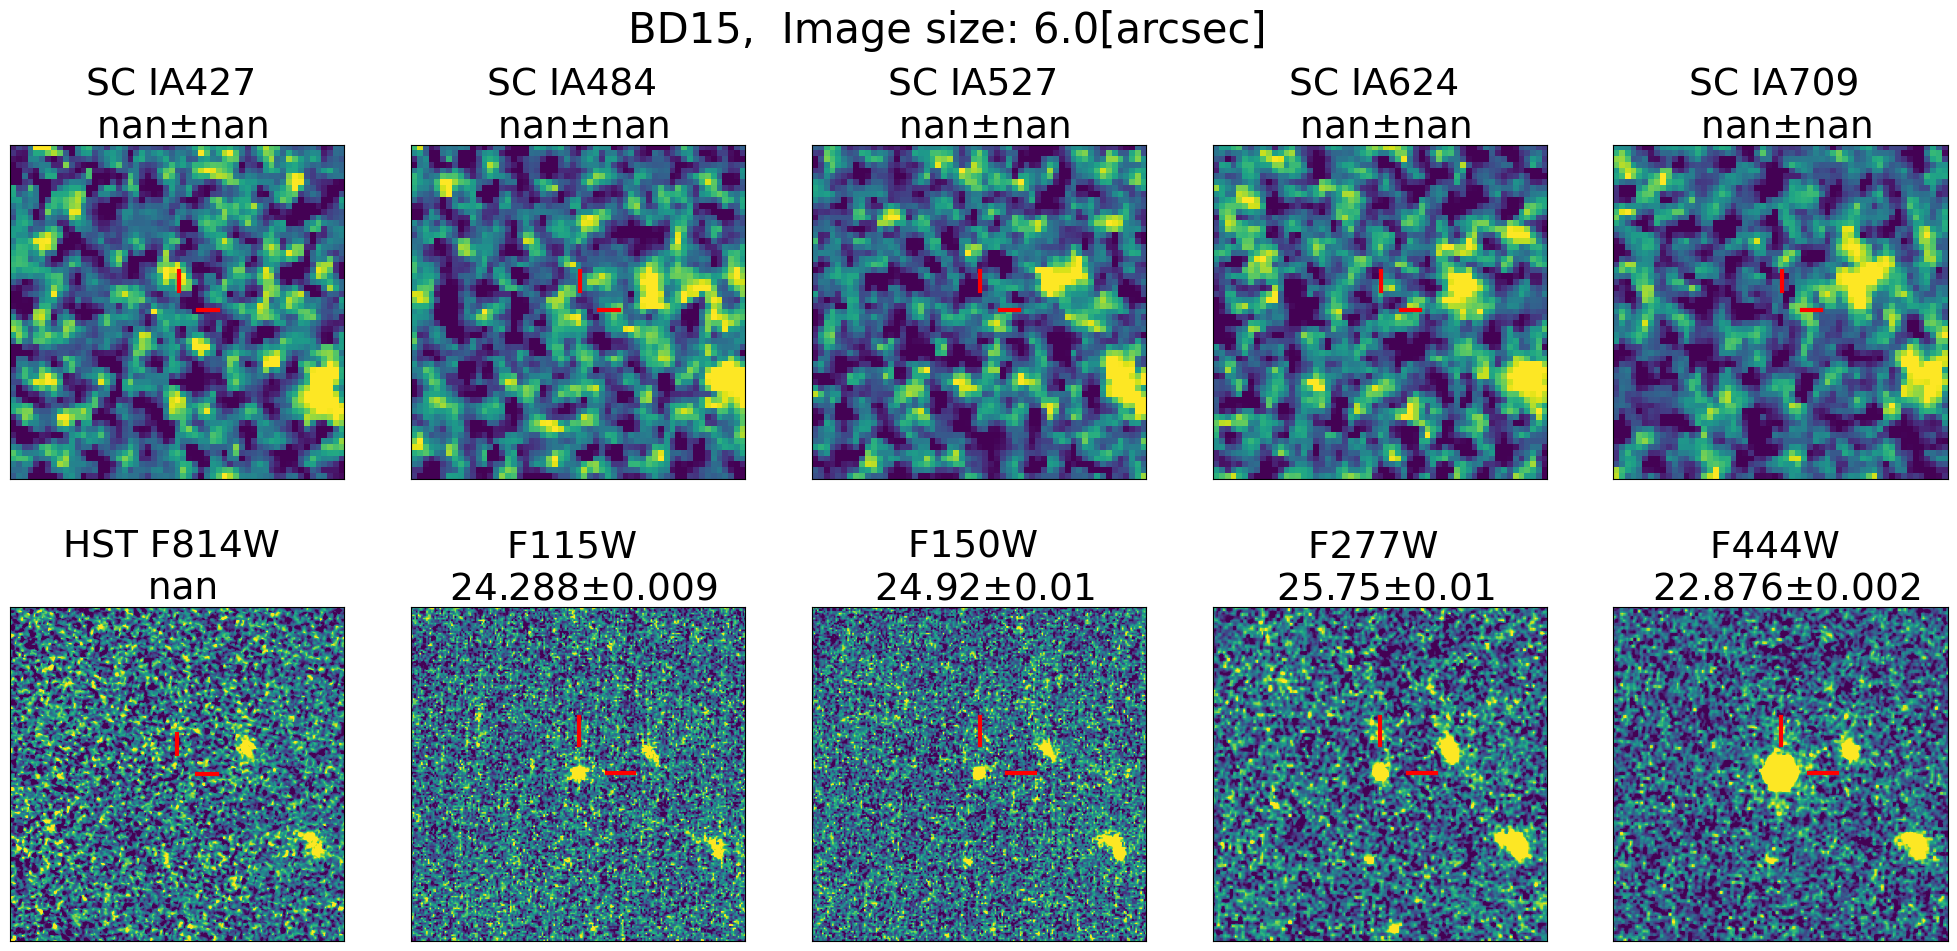

In [4]:
multi_filter_plot("0016", 6, size=100, percentage=[10, 90+8],
                # gsmooth=1.1,
                # offset=False,
                save=True
                )

BD24
A1: 17-20,
A2: 
A3: 8-9,
A4: 4-7 ** 4 is not shifted, lower one **
A5: 
A6: 16
A7: 10-15
A9: 21-24 
A10: 1-3

bd29
A1: 20-24,
A2: 11, 25
A3: 10-12,
A4: 4-9 ** 4 is not shifted, lower one **
A5: 
A6: 19
A7: 13-18
A9: 26-29 
A10: 1-3

bd30  
A1: 20-24,
A2:
A3: 9-12, 25-26
A4: 4-8 ** 4 is not shifted **
A5: 
A6: 19
A7: 13-18
A9: 27-30 
A10: 1-3

bd59
A1: 1-5,
A2:
A3: 30-43, 50-59
A4: 20-25, 
A5: 8, 9
A6: 6, 7
A7: 10-17, 19
A9: 18, 26-29, 
A10: 44-49

bd20
A1: 1, 2, 3, 4, 
A2:
A3: 19
A4: 12
A5:
A6: 5, 6
A7: 7, 8, 9, 10, 20
A9: 11, 13, 14, 15
A10: 16, 17, 18

In [34]:
loc = '/mnt/D/JWST_data/COSMOS-Webb/'
with fits.open(loc + f"30mas/SCI/mosaic_nircam_f115w_COSMOS-Web_30mas_A1_v0_5_SCI.fits") as hdul:
    images = hdul[1].data
    headers = hdul[1].header
    WCSs = WCS(hdul[1].header)
    pix_sizes = np.sqrt(hdul[1].header['PIXAR_A2'])

In [35]:
pix_sizes

0.03

### Large image inspection

In [20]:
def image_show(n, cat, cut, percentage = [5,99]):
    
    n = int(n)-1
    
    as2d=1/3600
    
    candi = pd.read_csv('../CentralDogma/5_Wrath_/magv5_eye_auto.csv')
    ra, dec = candi['ALPHA_J2000_F444W'][n], candi['DELTA_J2000_F444W'][n]
    print(ra, dec)
    
    f = pyfits.open(cat)
    f = f[0]
    w=WCS(f.header)            # get world coordinate information
    d2p_x=1/abs(f.header['CD1_1'])     # degree to pixel conversion, x-axis
    d2p_y=1/abs(f.header['CD2_2'])     # degree to pixel conversion, y-axis
    sky=w.world_to_pixel_values(ra,dec)
    size=(cut*as2d*d2p_x,cut*as2d*d2p_y)
    cutout=Cutout2D(f.data, sky, size, fill_value=np.nan)
    
    print(len(cutout.data[:,0]))
    
    vmin, vmax = np.nanpercentile(cutout.data, percentage)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(cutout.data, cmap='viridis', vmax=vmax, vmin=vmin)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    
    #flip y axis
    ax.invert_yaxis()
    # ax.invert_xaxis()

./images/subaru_mosaics/0005_149.77697745712106_1.9438663031222696_COSMOS.IA709.original-psf.v1.fits
149.7769783338399 1.9438679369374463
47


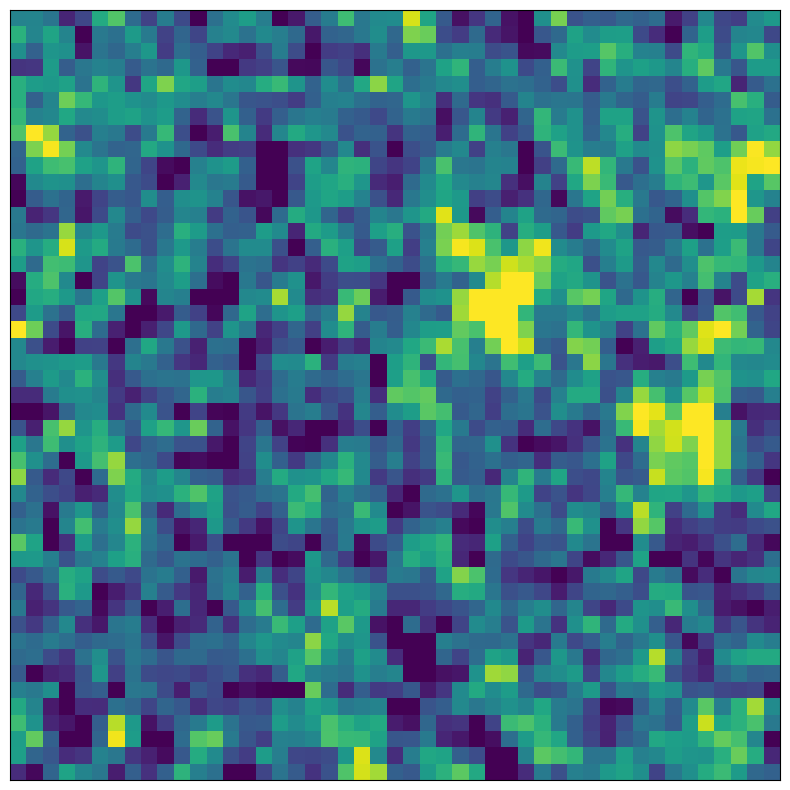

In [21]:
n = "0005"

loc = '/mnt/D/JWST_data/COSMOS-Webb/'
HST_file = glob.glob(f'./images/acs*/{n}_*.fits')
Subaru_file_r = sorted(glob.glob(f'./images/subaru*/{n}_*v1.fits'))

file = Subaru_file_r[8]
print(file)
image_show(n, file, 7)

In [18]:
f = fits.open(file)
cutout=Cutout2D(f[0].data, [23, 24], [-33, 33], fill_value=np.nan)
cutout.data

array([], shape=(0, 33), dtype='>f4')

In [42]:
Subaru_file_r

['./images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA427.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA464.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA484.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA505.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA527.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA574.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA624.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA679.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549417_COSMOS.IA709.original-psf.v1.fits',
 './images/subaru_mosaics/0001_149.79327085409673_2.150531512549

### Merge image

In [2]:
from PIL import Image

spec = sorted(glob.glob('/home/yuan/LePhare/lephare_dev/bd_fit/BD_20/Id0000000*.png'))
images = sorted(glob.glob('./BD_20/BD_*.png'))

for i in range(20):

    # Open the two PNG files
    image2 = Image.open(images[i])
    image1 = Image.open(spec[i])

    # Get the dimensions of the first image
    width1, height1 = image1.size

    # Get the dimensions of the second image
    width2, height2 = image2.size

    # Create a new image with a size that can accommodate both images
    new_height = height1 + height2 - 100
    # new_width = max(width1, width2)
    new_width = 2000 - 20
    merged_image = Image.new('RGB', (new_width, new_height))

    # Paste the first image onto the new image
    merged_image.paste(image1, (0, 0))

    # Paste the second image next to the first one
    merged_image.paste(image2, (-290, height1))

    # Save the merged image
    if i<9:
        merged_image.save(f'merged_bd_0{i+1}.png')
    else:
        merged_image.save(f'merged_bd_{i+1}.png')


In [130]:
2.5*35/40

2.1875

### cut image

In [31]:
from PIL import Image
import glob

images = sorted(glob.glob('./BD_24/BD_*.png'))

shift = 350
for i in range(23):
    img = Image.open(images[i])
    width, height = img.size
    print(width, height)
    # new_height = height - 100
    # new_width = width - shift
    new_height = 1000
    new_width = 2150
    merged_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))
    merged_image.paste(img, (-int(shift/2)+30, 0))
#     merged_image.paste(img, (50, 0))

    # merged_image.save(f'./BD_24/BD_01.png')
    if i<9:
            merged_image.save(f'./BD_24/BD_0{i+1}v.png')
    else:
            merged_image.save(f'./BD_24/BD_{i+1}v.png')

2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
2500 1100
